In [1]:
from jaxsnn.channels import synapse as syn

In [2]:
def synapse_dynamics(p: syn.SynapseParameters):
    def dynamics(s, u):
        return syn.dynamics(s, p)

    return dynamics


ampa_dynamics = synapse_dynamics(syn.ampa_parameters)
nmda_dynamics = synapse_dynamics(syn.nmda_parameters)
gaba_dynamics = synapse_dynamics(syn.martinotti_gaba_parameters)

In [3]:
from jaxsnn.base import explicit
from jaxsnn.base.types import ArrayLike
import tree_math


def synapse_projection(p: syn.SynapseParameters):
    def projection(x, u):
        x = syn.transition(w=u, s=x, p=p)
        return x

    return projection


ampa_projection = synapse_projection(syn.ampa_parameters)
nmda_projection = synapse_projection(syn.nmda_parameters)
gaba_projection = synapse_projection(syn.martinotti_gaba_parameters)


@tree_math.struct
class State:
    gaba: syn.SynapseState
    ampa: syn.SynapseState
    nmda: syn.SynapseState


@tree_math.struct
class Parameters:
    gaba: syn.SynapseParameters = syn.martinotti_gaba_parameters
    ampa: syn.SynapseParameters = syn.ampa_parameters
    nmda: syn.SynapseParameters = syn.nmda_parameters


def dynamics(s: State, _):
    return State(
        gaba=gaba_dynamics(s.gaba, _),
        ampa=ampa_dynamics(s.ampa, _),
        nmda=nmda_dynamics(s.nmda, _),
    )


def projection(x, u):
    return State(
        gaba=gaba_projection(x.gaba, u.gaba),
        ampa=ampa_projection(x.ampa, u.ampa),
        nmda=nmda_projection(x.nmda, u.nmda),
    )


def output(x, u):
    return x


equation = explicit.ExplicitConstrainedCDE(
    explicit_terms=dynamics, projection=projection, output=output
)

In [4]:
import jax
from jaxsnn.base import funcutils
import numpy as np

T = 2048
dt = 0.1
stim = np.zeros(T)
stim[1] = 1.0  # add a square pulse

stim = State(ampa=stim, nmda=stim, gaba=stim)

step_fn = explicit.classic_rk4_cde(equation, dt)
integrator = funcutils.controlled_trajectory(step_fn, stim)
integrator = jax.jit(integrator)

In [5]:
s = syn.SynapseState(a=0.0, b=0.0)
s = State(ampa=s, gaba=s, nmda=s)
_, sol = integrator(s)

/Users/cpehle/opt/miniconda3/envs/jaxsnn/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


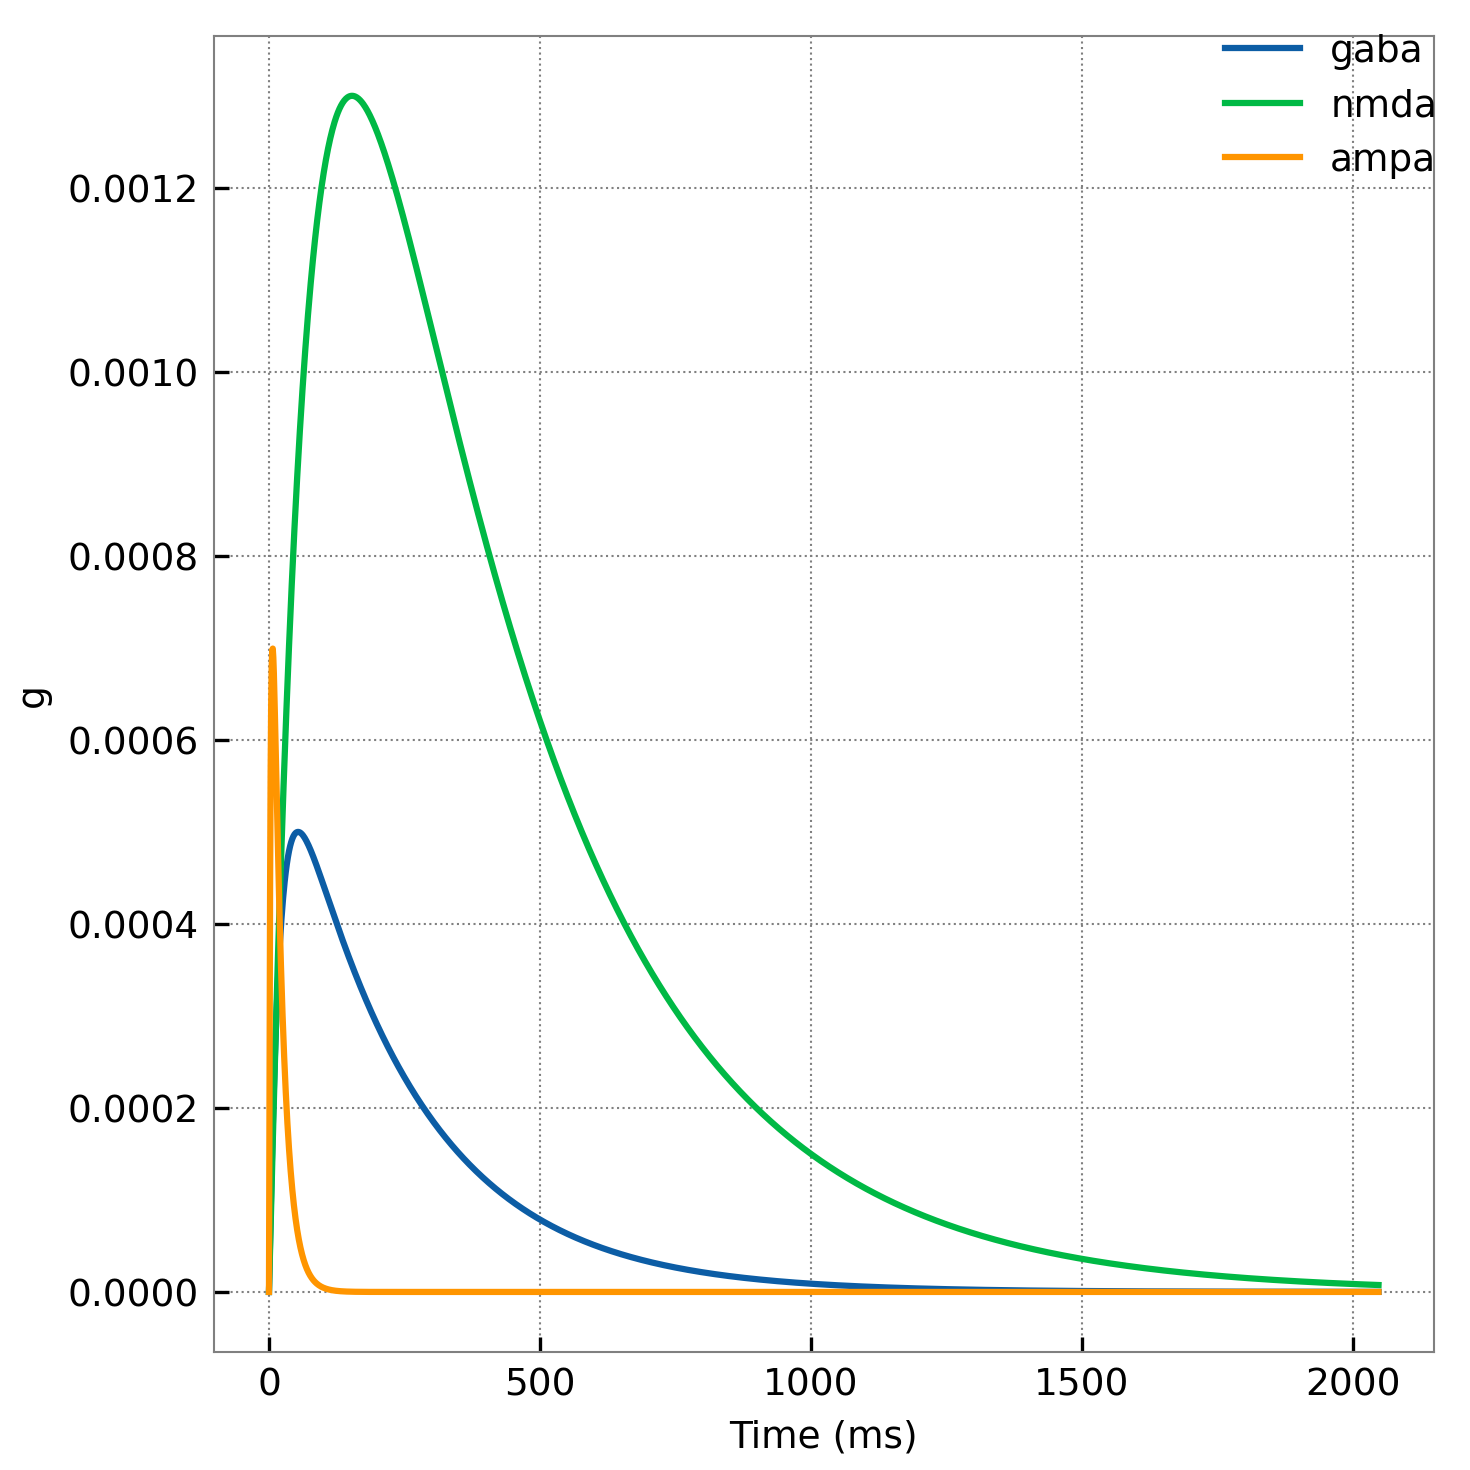

In [47]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler


plt.style.use("../doc/resources/matplotlibrc")

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5, 5), dpi=300)
ax.set_prop_cycle(
    cycler(
        "color",
        ["#0C5DA5", "#00B945", "#FF9500", "#FF2C00", "#845B97", "#474747", "#9e9e9e"],
    )
)
ax.plot(syn.g_syn(sol.gaba, syn.martinotti_gaba_parameters), label="gaba")
ax.plot(syn.g_syn(sol.nmda, syn.nmda_parameters), label="nmda")
ax.plot(syn.g_syn(sol.ampa, syn.ampa_parameters), label="ampa")

ax.set_xlabel("Time (ms)")
ax.set_ylabel("g")
fig.legend(loc="upper right", alignment="left")

In [24]:
import functools

fn = jax.value_and_grad(functools.partial(funcutils.controlled_trajectory, step_fn))

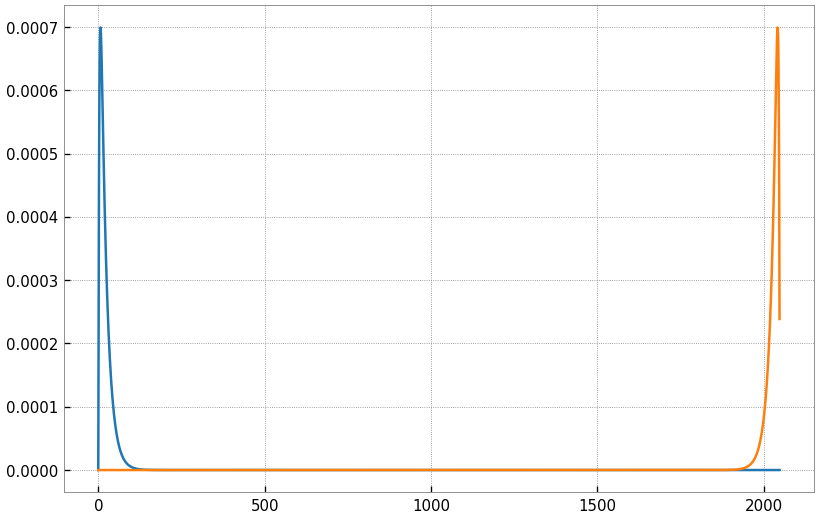

In [45]:
import jax.numpy as jnp


def input_integrator(stim):
    step_fn = explicit.classic_rk4_cde(equation, dt)
    integrator = funcutils.controlled_trajectory(step_fn, stim)
    s = syn.SynapseState(a=0.0, b=0.0)
    s = State(ampa=s, gaba=s, nmda=s)
    _, sol = integrator(s)
    g = syn.g_syn(sol.ampa, syn.ampa_parameters)
    return g[-1]


T = 2048
dt = 0.1
stim = np.zeros(T)
stim[1] = 1.0  # add a square pulse
stim = State(ampa=jnp.array(stim), nmda=jnp.array(stim), gaba=jnp.array(stim))

fn = jax.value_and_grad(input_integrator)
out, grad = fn(stim)

plt.plot(syn.g_syn(sol.ampa, syn.ampa_parameters))
plt.plot(grad.ampa)